# Tutorial: Basics and Utilization of PySINDy
This notebook serves as an overview of how PySINDy works and how to use it. Two examples will be worked out. The two examples in this notebook are preexisting and were compiled from separate notebooks on [GitHub](https://github.com/dynamicslab/pysindy) to show what SINDy is and create a basic knowledge of how it works. Additional ODE examples will be worked out on a separate document using the same steps with the addition of comparing different submodules.

### Background: Overview of SINDy

* SINDy = Sparse Identification of Nonlinear Dynamical systems
* A computer algorithm used to analyze Differential Equations and predict their future behavior
* SINDy can also create a linear regression for raw time-series data to predict its future behavior

---


In order for SINDy to work, it needs a set of time-series data, which can be turned into two separate matrices $X$ and $\dot X$, which can be defined as:

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}
$$

It also needs a library matrix $\Theta(X)$, which is a set of monomials that gets applied to the time-series data, defined by:

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid 
	\end{bmatrix}
$$


Finally, a set of coefficient vectors need to be collected into the matrix:

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}
$$



Now, with each of the objects $X$, $\dot X$, $\Theta(X)$, and $\Xi$ being defined, the approximation equation underlying SINDy can be written down:

$$ \dot X \approx \Theta(X) \Xi $$

### Background: What is PySINDy?

PySINDy consists of three main submodules which are intended to emulate SINDy. Each module is meant to compute a different portion of the approximation equation mentioned directly above.

* `pysindy.differentiate` computes $\dot X$ from $X$

* `pysindy.feature_library` forms $\Theta(X)$

* `pysindy.optimizers` determines $\Xi$



# Examples of implementing PySINDy

Begin by importing the Numpy and PySINDy modules. Other modules will need to be imported later for plotting, but these are a good starting point.

In [2]:
import numpy as np
import pysindy as ps

## Part 1: A System of Equations

This first example will look at the following system of a particle over time. 
    
$$
	\frac{d}{dt} \begin{bmatrix} x \\ y \end{bmatrix}
	= \begin{bmatrix} -2x \\ y \end{bmatrix}
	= \begin{bmatrix} -2 & 0 \\ 0 & 1 \end{bmatrix}
	\begin{bmatrix} x \\ y \end{bmatrix}
$$

The system of differential equations (DE's) can be coupled into two separate DE's with simple solutions of $x(t) = x_0e^{-2t}$ and $y(t) = y_0e^t$, with initial conditions of $x_0 = x(0)$ and $y_0=y(0)$.

Utilizing the initial conditions $x_0 = 3$ and $y_0 = \tfrac{1}{2}$, a matrix $X$ can be constructed and defined.

In [12]:
t = np.linspace(0,1,1001) #Data points for time
x = 3*np.exp(-2*t) 
y = (1/2)*np.exp(t)

X = np.stack((x,y),axis=-1) #Creates the X matrix from the defined equations

After implementing these intial conditions, it is time to use the different modules of **PySINDy**. 

The `ps.differentiation` submodule includes many different differentiation methods. For this example, the `FiniteDifference` method will be used.

In [13]:
diff = ps.differentiation.FiniteDifference(order=2)

The next step is to use the `ps.feature_library` submodule to define the object which will be passed into the `SINDy` object. For this example, `PolynomialLibrary` will be used. Other libraries can be found [here](https://pysindy.readthedocs.io/en/latest/api/pysindy.feature_library.html).

In [58]:
lib = ps.feature_library.PolynomialLibrary(degree=3)

Finally, the [optimizer](https://github.com/dynamicslab/pysindy/blob/master/examples/data/optimizer_summary.jpg) needs to be selected using the `ps.optimizers` submodule. The `STLSQ` optimizer will be used in this example.

In [59]:
opt = ps.optimizers.STLSQ(threshold=0.2)

At this point, the three different components need to be brought together to create a single `SINDy` model.

In [60]:
model = ps.SINDy(
    differentiation_method = diff,
    feature_library = lib,
    optimizer = opt,
    feature_names = ["x","y"]
)

Next, the data needs to be fit.

In [61]:
model.fit(X,t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

The equations can now be checked to see if they are reasonable. Running this, they match what is to be expected.

In [62]:
model.print()

(x)' = -2.000 x
(y)' = 1.000 y


Now that the SINDy model has been fit, it can be used to look at different intitial conditions as we move forward in time using the `simulate` function.

In [63]:
x0 = 6
y0 = -0.1

t_t = np.linspace(0,1,1001)
x_t = x0*np.exp(-2*t_t)
y_t = y0*np.exp(t_t)

sim = model.simulate([x0,y0],t=t_t)

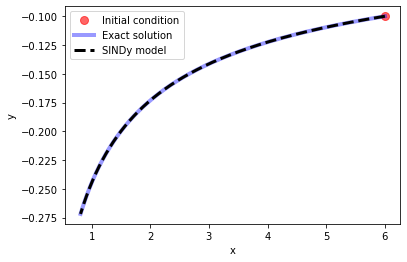

In [64]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_t, y_t, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Part 2: A Simple Harmonic Oscillator

We will now be looking at a linear, damped harmonic oscillator.

Import additional packages.

In [79]:
from scipy.integrate import solve_ivp

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

Define the ODE that will be solved

In [80]:
def linear_damped_SHO(t, x):
    return [-0.1 * x[0] + 2 * x[1], -2 * x[0] - 0.1 * x[1]]

Create the training data by defining step size and using the equation for a Simple Harmonic Oscillator (SHO).

In [81]:
x0 = 2
y0 = 0

dt = 0.01
t_train = np.arange(0,25,dt)
t_span = (t_train[0],t_train[-1])
x0_train = [x0,y0] #Initial conditions can be changed, this is just an example
x_train = solve_ivp(linear_damped_SHO,t_span,
                   x0_train,t_eval=t_train,**integrator_keywords).y.T

Fit the data.

In [82]:
p_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer = ps.STLSQ(threshold=threshold),
    feature_library = ps.PolynomialLibrary(degree=p_order),
)

Create the model as well as print it to make sure they match what is to be expected.

In [83]:
model.fit(x_train,t=dt)
model.print()

(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1


Plot the model as well as the governing equation. It can be seen on the left plot that the SINDy model starts with the inital conditions stated above and continues to plot the future behavior. The plot on the right plots $x_1$ vs. $x_2$. Since the original example did not include the location of the intitial conditions, I have included it make the direction of the model more visible.

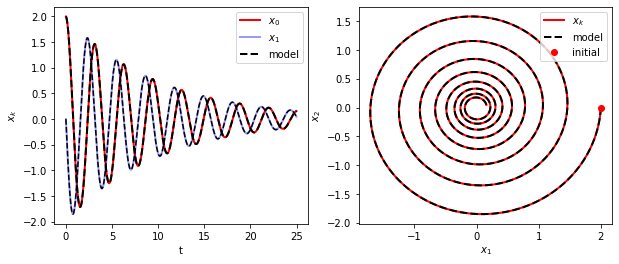

In [84]:
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].plot(x0,y0,"ro",label="initial")
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

## Summary of Steps

In general, this technique can be broken down into various steps to ensure the correct results. Within each step, there are certain variables that can be changed as each equation is different for the set of date.

In general, the steps are as follows:

1. Import any intial packages that need to be used. The two basic ones that should always be imported are `Numpy` and `PySINDy`.

2. Create training data from the intial conditions. This is usually created from a system of equations. 

3. Define the `differentiation method`. This has multiple different attributes which can be changed.

4. Define the `object` which will be passed into SINDy. This also has many attributes which can be changed.

5. Define the `optimizer`.  Again, this has many attributes that can change.

6. Fit the model using the training data.

7. Print out the model to see if the equations match with what is expected. (Optional)

8. Plot the governing equations as well as the model data to see how similar they are.

This method doesn't always work perfectly with every data set. Sometimes, it takes trying different combinations of steps 3-5 to get the ideal outcome. This is explored more in the next notebook.

 ## Additional Resources

The above information was compliled to give an overview of PySINDy as well as provide different examples on how it can be used. Additional reading and examples can be found on [GitHub](https://github.com/dynamicslab/pysindy).

There are also videos available on YouTube to explain [SINDy](https://www.youtube.com/watch?v=NxAn0oglMVw) and [PySINDy](https://www.youtube.com/watch?v=DvbbXX8Bd90).